In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Load advanced splits (contains both OBP and BABIP)
adv_lhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-LHB-empty-adv-2015-2024.csv')
adv_rhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-RHB-empty-adv-2015-2024.csv')
nonadv_lhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-LHB-empty-2015-2024.csv')
nonadv_rhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-RHB-empty-2015-2024.csv')



# Select metrics and add handedness
df_lhb = adv_lhb[['Season', 'OBP', 'BABIP']].copy()
df_lhb['Handedness'] = 'LHB'
df_rhb = adv_rhb[['Season', 'OBP', 'BABIP']].copy()
df_rhb['Handedness'] = 'RHB'

# Combine and pivot
df = pd.concat([df_lhb, df_rhb], ignore_index=True)
pivot = df.pivot(index='Season', columns='Handedness', values=['OBP', 'BABIP']).sort_index()

# Compute DID for each relevant season
years = [y for y in pivot.index if y >= 2016]
did_rows = []
for year in years:
    prev = year - 1
    did_babip = (pivot.loc[year, ('BABIP', 'LHB')] - pivot.loc[prev, ('BABIP', 'LHB')]) - \
                (pivot.loc[year, ('BABIP', 'RHB')] - pivot.loc[prev, ('BABIP', 'RHB')])
    did_obp = (pivot.loc[year, ('OBP', 'LHB')] - pivot.loc[prev, ('OBP', 'LHB')]) - \
              (pivot.loc[year, ('OBP', 'RHB')] - pivot.loc[prev, ('OBP', 'RHB')])
    did_rows.append({'Season': year, 'DID_BABIP': did_babip, 'DID_OBP': did_obp})

did_df = pd.DataFrame(did_rows)

print(did_df)

   Season  DID_BABIP   DID_OBP
0    2016  -0.008729 -0.005793
1    2017   0.004211  0.004305
2    2018  -0.003490 -0.001735
3    2019   0.003047 -0.000370
4    2020  -0.020491 -0.014349
5    2021   0.016689  0.008922
6    2022  -0.009412 -0.006266
7    2023   0.009446  0.009451
8    2024  -0.001470 -0.001007


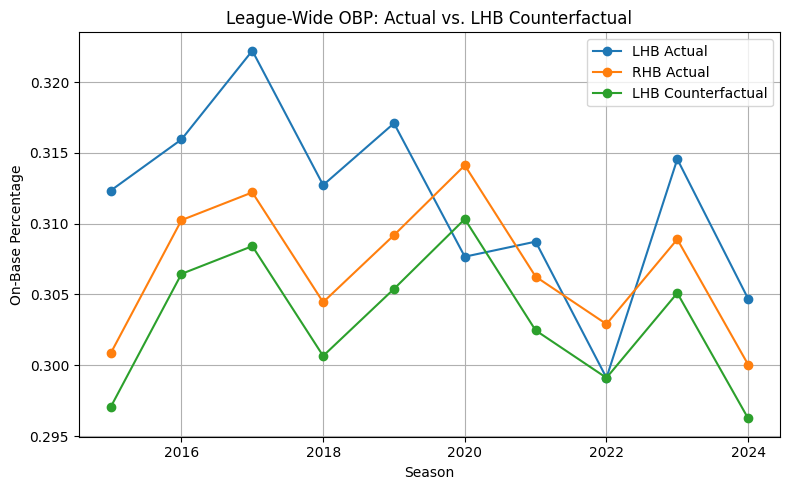

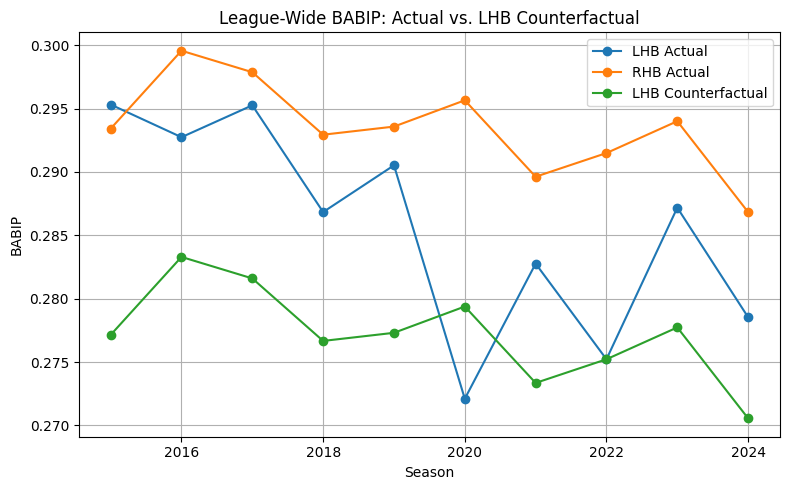

In [12]:
# 2. Prepare a long DataFrame and pivot to wide
df_lhb = adv_lhb[['Season', 'OBP', 'BABIP']].assign(Hand='LHB')
df_rhb = adv_rhb[['Season', 'OBP', 'BABIP']].assign(Hand='RHB')
df = pd.concat([df_lhb, df_rhb], ignore_index=True)
pivot = df.pivot(index='Season', columns='Hand', values=['OBP', 'BABIP']).sort_index()

# 3. Define the baseline (pre‐ban) year for counterfactual
base_year = 2022
base_lhb_obp   = pivot.loc[base_year, ('OBP',   'LHB')]
base_rhb_obp   = pivot.loc[base_year, ('OBP',   'RHB')]
base_lhb_babip = pivot.loc[base_year, ('BABIP', 'LHB')]
base_rhb_babip = pivot.loc[base_year, ('BABIP', 'RHB')]

# 4. Compute the LHB counterfactual series by applying RHB changes
pivot['CF_OBP_LHB']   = base_lhb_obp   + (pivot[('OBP',   'RHB')] - base_rhb_obp)
pivot['CF_BABIP_LHB'] = base_lhb_babip + (pivot[('BABIP', 'RHB')] - base_rhb_babip)

# 5. Plot OBP: Actual vs. Counterfactual
plt.figure(figsize=(8, 5))
plt.plot(pivot.index, pivot[('OBP',   'LHB')],   marker='o', label='LHB Actual')
plt.plot(pivot.index, pivot[('OBP',   'RHB')],   marker='o', label='RHB Actual')
plt.plot(pivot.index, pivot['CF_OBP_LHB'],       marker='o', label='LHB Counterfactual')
plt.xlabel('Season')
plt.ylabel('On-Base Percentage')
plt.title('League-Wide OBP: Actual vs. LHB Counterfactual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Plot BABIP: Actual vs. Counterfactual
plt.figure(figsize=(8, 5))
plt.plot(pivot.index, pivot[('BABIP', 'LHB')],   marker='o', label='LHB Actual')
plt.plot(pivot.index, pivot[('BABIP', 'RHB')],   marker='o', label='RHB Actual')
plt.plot(pivot.index, pivot['CF_BABIP_LHB'],     marker='o', label='LHB Counterfactual')
plt.xlabel('Season')
plt.ylabel('BABIP')
plt.title('League-Wide BABIP: Actual vs. LHB Counterfactual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()